In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
import osmnx

%matplotlib inline

In [2]:
#os.listdir()

#### Informações gerais sobre os arquivos

O intuito era gerar um script que lesse os dados necessários para cada ano, mas verificou-se que nos 4 anos entre as eleições alguns detalhes dos arquivos se modificavam, por exemplo:

- Variação nos formatos dos arquivos: o mesmo tipo de arquivo em um ano está como .txt e em outro como .csv;
- Variação nas colunas dos arquivos - variáveis novas / variáveis que foram descartadas;

#### Sobre os arquivos usados:

* df_det_{ano} - (detalhe_votacao_munzona_{ano}): Dataframe com os detalhes da eleição, com infos sobre abstenções, votos brancos e nulos, etc.


* df_secao_{ano} - (votacao_secao_{ano}_SP): Dataframe com votos por seção eleitoral


* df_votos_{ano} - (votacao_candidato_munzona_{ano}): Dataframe com votos consolidados por candidato e cidade


O download dos 3 arquivos principais foi feito manualmente, diretamente do site do TSE através do link:
https://www.tse.jus.br/hotsites/pesquisas-eleitorais/resultados.html

### Juntando dataframes dos dois anos para cada um dos tipos de arquivos

In [3]:
df_det_2016 = pd.read_csv("./detalhe_votacao_munzona_2016/detalhe_votacao_munzona_2016_SP.csv", sep =";", encoding = 'latin-1')
df_det_2020 = pd.read_csv("./detalhe_votacao_munzona_2020/detalhe_votacao_munzona_2020_SP.csv", sep =";", encoding = 'latin-1')
print(df_det_2016.columns.unique())
print(df_det_2020.columns.unique())

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'CD_CARGO', 'DS_CARGO', 'QT_APTOS',
       'QT_SECOES', 'QT_SECOES_AGREGADAS', 'QT_APTOS_TOT', 'QT_SECOES_TOT',
       'QT_COMPARECIMENTO', 'QT_ABSTENCOES', 'ST_VOTO_EM_TRANSITO',
       'QT_VOTOS_NOMINAIS', 'QT_VOTOS_BRANCOS', 'QT_VOTOS_NULOS',
       'QT_VOTOS_LEGENDA', 'QT_VOTOS_PENDENTES', 'QT_VOTOS_ANULADOS',
       'HH_ULTIMA_TOTALIZACAO', 'DT_ULTIMA_TOTALIZACAO'],
      dtype='object')
Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'CD_CARGO', 'DS_CARGO', 'QT_APTOS',
       'QT_SECOES', 'QT_SECOES_AGREGADAS', 'QT_APTOS_TOT', 'QT_SEC

Confirmando se todas as colunas são iguais em 2016 e 2020 para os 3 dataframes:

In [4]:
a = set(df_det_2016.columns.unique())
b = set(df_det_2020.columns.unique())

a == b

False

In [5]:
print(len(a))
print(len(b))

34
37


Temos 3 variáveis novas neste tipo de arquivo em 2020 com relação a 2016. Inspecionando as colunas verificamos que são:

- 'QT_VOTOS_NULO_TECNICO', 'QT_VOTOS_ANULADO_SUB_JUDICE' e 'QT_VOTOS_SEM_CAND_P_VOTAR'

A documentação de 2020 não comenta sobre estas novas variáveis. Para efeitos das análises deste notebook estas variáveis serão excluídas
    

In [6]:
novas_vars = ['QT_VOTOS_NULO_TECNICO', 'QT_VOTOS_ANULADO_SUB_JUDICE', 'QT_VOTOS_SEM_CAND_P_VOTAR']
df_det_2020 = df_det_2020.drop(novas_vars, axis = 1)

In [7]:
df_secao_2016 = pd.read_csv("./votacao_secao_2016_SP/votacao_secao_2016_SP.txt", sep =";", encoding = 'latin-1', header = None)
df_secao_2016 = df_secao_2016.rename(columns={0:'DT_GERACAO', 1:'HH_GERACAO', 2:'ANO_ELEICAO', 3:'NR_TURNO', 4:'DS_ELEICAO',
                 5:'SG_UF', 6:'SG_UE', 7:'CD_MUNICIPIO', 8:'NM_MUNICIPIO', 9:'NR_ZONA', 10:'NR_SECAO',
                 11: 'CD_CARGO', 12: 'DS_CARGO',13:'NM_VOTAVEL',14:'QT_VOTOS'})

df_secao_2020 = pd.read_csv("./votacao_secao_2020_SP/votacao_secao_2020_SP.txt", sep =";", encoding = 'latin-1')
print(df_secao_2016.columns.unique())
print(df_secao_2020.columns.unique())

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'NR_TURNO', 'DS_ELEICAO',
       'SG_UF', 'SG_UE', 'CD_MUNICIPIO', 'NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO',
       'CD_CARGO', 'DS_CARGO', 'NM_VOTAVEL', 'QT_VOTOS'],
      dtype='object')
Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'NR_SECAO', 'CD_CARGO', 'DS_CARGO',
       'NR_VOTAVEL', 'NM_VOTAVEL', 'QT_VOTOS', 'NR_LOCAL_VOTACAO'],
      dtype='object')


In [8]:
a = set(df_secao_2016.columns.unique())
b = set(df_secao_2020.columns.unique())

to_drop = list((b-a))
to_drop

['NR_VOTAVEL',
 'CD_TIPO_ELEICAO',
 'TP_ABRANGENCIA',
 'CD_ELEICAO',
 'NM_UE',
 'NR_LOCAL_VOTACAO',
 'NM_TIPO_ELEICAO',
 'DT_ELEICAO']

In [9]:
df_secao_2020 = df_secao_2020.drop(to_drop, axis = 1)

In [10]:
a = set(df_secao_2016.columns.unique())
b = set(df_secao_2020.columns.unique())

a == b

True

In [11]:
df_votos_2016 = pd.read_csv("./votacao_candidato_munzona_2016/votacao_candidato_munzona_2016_SP.csv", sep =";", encoding = 'latin-1')

df_votos_2020 = pd.read_csv("./votacao_candidato_munzona_2020/votacao_candidato_munzona_2020_SP.csv", sep =";", encoding = 'latin-1')
print(df_votos_2016.columns.unique())
print(df_votos_2020.columns.unique())

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'CD_CARGO', 'DS_CARGO', 'SQ_CANDIDATO',
       'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'CD_SITUACAO_CANDIDATURA',
       'DS_SITUACAO_CANDIDATURA', 'CD_DETALHE_SITUACAO_CAND',
       'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO',
       'NM_PARTIDO', 'SQ_COLIGACAO', 'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO',
       'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO', 'ST_VOTO_EM_TRANSITO',
       'QT_VOTOS_NOMINAIS'],
      dtype='object')
Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA'

In [12]:
a = set(df_votos_2016.columns.unique())
b = set(df_votos_2020.columns.unique())

a == b

True

A conferência de variáveis entre os dataframes é um ótimo exemplo para ilustrar o uso da estrutura "set" em python. Sets são similares a listas, com a diferença crucial de que a ordem para os itens não importa. Se tivéssemos usado uma lista para armazenar as colunas para em seguida fazer a==b poderíamos chegar em uma conclusão errada sobre existência de colunas duplicadas, pois poderia ser apenas o caso de que a correspondência não era exata. Usando set, garantimos que todo mundo será comparado com todo mundo e chegar uma conclusão mais assertiva

### Vamos explorar primeiros os dados de detalhes, os que vão dizer abstenções, votos brancos e nulos, etc.

In [13]:
df_det_2016_2020 = pd.concat([df_det_2016,df_det_2020])

In [14]:
df_det_2016_2020.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,...,QT_ABSTENCOES,ST_VOTO_EM_TRANSITO,QT_VOTOS_NOMINAIS,QT_VOTOS_BRANCOS,QT_VOTOS_NULOS,QT_VOTOS_LEGENDA,QT_VOTOS_PENDENTES,QT_VOTOS_ANULADOS,HH_ULTIMA_TOTALIZACAO,DT_ULTIMA_TOTALIZACAO
0,18/10/2020,00:06:22,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,...,32564,N,84380,16194,19508,15086,0,0,14:11:09,26/06/2018
1,18/10/2020,00:06:22,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,...,408,N,2086,16,61,0,0,0,18:27:34,02/10/2016
2,18/10/2020,00:06:22,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,...,20979,N,53070,2264,4101,0,0,0,14:00:00,28/10/2016
3,18/10/2020,00:06:22,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,...,16456,N,62631,4522,7616,0,0,0,19:01:44,02/10/2016
4,18/10/2020,00:06:22,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,...,1231,N,5211,114,413,306,0,0,18:43:52,02/10/2016


In [15]:
# Filtrando para Jundiaí e cargo de vereador

df_det_2016_2020 = df_det_2016_2020[df_det_2016_2020["NM_MUNICIPIO"] == 'JUNDIAÍ']
df_det_2016_2020 = df_det_2016_2020[df_det_2016_2020["CD_CARGO"] == 13]

In [16]:
df_det_2016_2020.groupby(['NM_MUNICIPIO','ANO_ELEICAO'])['QT_APTOS','QT_COMPARECIMENTO','QT_ABSTENCOES', 'QT_VOTOS_NOMINAIS', 'QT_VOTOS_BRANCOS', 'QT_VOTOS_NULOS', 'QT_VOTOS_LEGENDA'].sum()


#['QT_APTOS','QT_COMPARECIMENTO','QT_ABSTENCOES', 'QT_VOTOS_NOMINAIS', 'QT_VOTOS_BRANCOS', 'QT_VOTOS_NULOS']


<ipython-input-16-06a89efd9cf7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_det_2016_2020.groupby(['NM_MUNICIPIO','ANO_ELEICAO'])['QT_APTOS','QT_COMPARECIMENTO','QT_ABSTENCOES', 'QT_VOTOS_NOMINAIS', 'QT_VOTOS_BRANCOS', 'QT_VOTOS_NULOS', 'QT_VOTOS_LEGENDA'].sum()


QT_APTOS  QT_COMPARECIMENTO  QT_ABSTENCOES  \
NM_MUNICIPIO ANO_ELEICAO                                               
JUNDIAÍ      2016           290278             241046          49232   
             2020           314875             228515          86360   

                          QT_VOTOS_NOMINAIS  QT_VOTOS_BRANCOS  QT_VOTOS_NULOS  \
NM_MUNICIPIO ANO_ELEICAO                                                        
JUNDIAÍ      2016                    187135             14299           24040   
             2020                    181924             13964           19061   

                          QT_VOTOS_LEGENDA  
NM_MUNICIPIO ANO_ELEICAO                    
JUNDIAÍ      2016                    15572  
             2020                    13028

In [17]:
c = df_det_2016_2020.groupby(['NM_MUNICIPIO','ANO_ELEICAO'])['QT_APTOS','QT_COMPARECIMENTO','QT_ABSTENCOES', 'QT_VOTOS_NOMINAIS', 'QT_VOTOS_BRANCOS', 'QT_VOTOS_NULOS', 'QT_VOTOS_LEGENDA'].sum().reset_index()

<ipython-input-17-f96f7594821d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  c = df_det_2016_2020.groupby(['NM_MUNICIPIO','ANO_ELEICAO'])['QT_APTOS','QT_COMPARECIMENTO','QT_ABSTENCOES', 'QT_VOTOS_NOMINAIS', 'QT_VOTOS_BRANCOS', 'QT_VOTOS_NULOS', 'QT_VOTOS_LEGENDA'].sum().reset_index()


In [18]:
c

,NM_MUNICIPIO,ANO_ELEICAO,QT_APTOS,QT_COMPARECIMENTO,QT_ABSTENCOES,QT_VOTOS_NOMINAIS,QT_VOTOS_BRANCOS,QT_VOTOS_NULOS,QT_VOTOS_LEGENDA
0,JUNDIAÍ,2016,290278,241046,49232,187135,14299,24040,15572
1,JUNDIAÍ,2020,314875,228515,86360,181924,13964,19061,13028


In [19]:
print("Houve um aumento no número de eleitores aptos em Jundiaí entre 2016 e 2020, de {} para {}, o que equivale a {} novos eleitores".format(c.loc[0][2],c.loc[1][2], c.loc[1][2]-c.loc[0][2]))

Houve um aumento no número de eleitores aptos em Jundiaí entre 2016 e 2020, de 290278 para 314875, o que equivale a 24597 novos eleitores


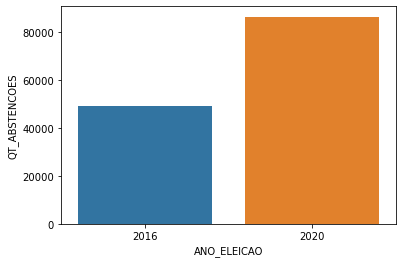

In [20]:
ax = sns.barplot(x="ANO_ELEICAO", y="QT_ABSTENCOES", data=c)

In [21]:
print("Houve um grande número de abstenções em 2020, de {} eleitores, o que representa {}% do total de eleitores aptos. Em 2016 este percentual foi de {} %".format(c.loc[1][4],round((c.loc[1][4]/c.loc[1][2])*100,2),round((c.loc[0][4]/c.loc[0][2])*100,2)))

Houve um grande número de abstenções em 2020, de 86360 eleitores, o que representa 27.43% do total de eleitores aptos. Em 2016 este percentual foi de 16.96 %


### Carregando o arquivo que consolida os dados referentes à votação dos candidatos
(não considera brancos, nulos e abstenções)

In [22]:
df_votos_2016_2020 = pd.concat([df_votos_2016,df_votos_2020])

In [23]:
pd.set_option('max_columns', None)
df_votos_2016_2020.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,CD_CARGO,DS_CARGO,SQ_CANDIDATO,NR_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_SOCIAL_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,CD_DETALHE_SITUACAO_CAND,DS_DETALHE_SITUACAO_CAND,TP_AGREMIACAO,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,SQ_COLIGACAO,NM_COLIGACAO,DS_COMPOSICAO_COLIGACAO,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,ST_VOTO_EM_TRANSITO,QT_VOTOS_NOMINAIS
0,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,71072,SÃO PAULO,71072,SÃO PAULO,252,13,Vereador,250000022074,13110,ALFREDO ALVES CAVALCANTE,ALFREDINHO,#NULO#,12,APTO,2,DEFERIDO,Coligação,13,PT,Partido dos Trabalhadores,250000001322,"PT, PDT, PR E PROS",PT / PDT / PR / PROS,2,ELEITO POR QP,N,17
1,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,71072,SÃO PAULO,71072,SÃO PAULO,371,13,Vereador,250000022111,22611,ANTONIO DE PAIVA MONTEIRO FILHO,TONINHO PAIVA,#NULO#,12,APTO,2,DEFERIDO,Coligação,22,PR,Partido da República,250000001322,"PT, PDT, PR E PROS",PT / PDT / PR / PROS,2,ELEITO POR QP,N,7
2,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,71072,SÃO PAULO,71072,SÃO PAULO,392,13,Vereador,250000022124,22401,NOEMI PEREIRA NONATO,NOEMI NONATO,#NULO#,12,APTO,2,DEFERIDO,Coligação,22,PR,Partido da República,250000001322,"PT, PDT, PR E PROS",PT / PDT / PR / PROS,2,ELEITO POR QP,N,554
3,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,71072,SÃO PAULO,71072,SÃO PAULO,374,13,Vereador,250000022100,13800,SENIVAL PEREIRA DE MOURA,SENIVAL MOURA,#NULO#,12,APTO,2,DEFERIDO,Coligação,13,PT,Partido dos Trabalhadores,250000001322,"PT, PDT, PR E PROS",PT / PDT / PR / PROS,2,ELEITO POR QP,N,32
4,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,71072,SÃO PAULO,71072,SÃO PAULO,389,13,Vereador,250000022074,13110,ALFREDO ALVES CAVALCANTE,ALFREDINHO,#NULO#,12,APTO,2,DEFERIDO,Coligação,13,PT,Partido dos Trabalhadores,250000001322,"PT, PDT, PR E PROS",PT / PDT / PR / PROS,2,ELEITO POR QP,N,262


In [24]:
df_votos_2016_2020.columns

Index(['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO',
       'NM_TIPO_ELEICAO', 'NR_TURNO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO',
       'TP_ABRANGENCIA', 'SG_UF', 'SG_UE', 'NM_UE', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 'NR_ZONA', 'CD_CARGO', 'DS_CARGO', 'SQ_CANDIDATO',
       'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
       'NM_SOCIAL_CANDIDATO', 'CD_SITUACAO_CANDIDATURA',
       'DS_SITUACAO_CANDIDATURA', 'CD_DETALHE_SITUACAO_CAND',
       'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO',
       'NM_PARTIDO', 'SQ_COLIGACAO', 'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO',
       'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO', 'ST_VOTO_EM_TRANSITO',
       'QT_VOTOS_NOMINAIS'],
      dtype='object')

In [25]:
df_jund = df_votos_2016_2020[df_votos_2016_2020["NM_MUNICIPIO"] == "JUNDIAÍ"]

In [26]:
df_jund.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,CD_CARGO,DS_CARGO,SQ_CANDIDATO,NR_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,NM_SOCIAL_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,CD_DETALHE_SITUACAO_CAND,DS_DETALHE_SITUACAO_CAND,TP_AGREMIACAO,NR_PARTIDO,SG_PARTIDO,NM_PARTIDO,SQ_COLIGACAO,NM_COLIGACAO,DS_COMPOSICAO_COLIGACAO,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,ST_VOTO_EM_TRANSITO,QT_VOTOS_NOMINAIS
2876,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,66192,JUNDIAÍ,66192,JUNDIAÍ,281,13,Vereador,250000024165,40040,OSVALDO CASCAIS SANTOS,DIVA (OSVALDO CASCAIS),#NULO#,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,Partido Socialista Brasileiro,250000001465,PARTIDO ISOLADO,PSB,5,SUPLENTE,N,22
2877,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,66192,JUNDIAÍ,66192,JUNDIAÍ,281,13,Vereador,250000024171,40412,DENILCE JOSEFINA NICOLA,DENILCE NICOLA,#NULO#,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,Partido Socialista Brasileiro,250000001465,PARTIDO ISOLADO,PSB,5,SUPLENTE,N,108
2878,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,66192,JUNDIAÍ,66192,JUNDIAÍ,65,13,Vereador,250000024174,40333,LUZIA BRIGONI,LUZIA BRIGONI,#NULO#,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,Partido Socialista Brasileiro,250000001465,PARTIDO ISOLADO,PSB,5,SUPLENTE,N,7
2879,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,66192,JUNDIAÍ,66192,JUNDIAÍ,424,13,Vereador,250000024171,40412,DENILCE JOSEFINA NICOLA,DENILCE NICOLA,#NULO#,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,Partido Socialista Brasileiro,250000001465,PARTIDO ISOLADO,PSB,5,SUPLENTE,N,35
2880,18/10/2020,00:09:33,2016,2,Eleição Ordinária,1,220,ELEIÇÕES MUNICIPAIS 2016,02/10/2016,M,SP,66192,JUNDIAÍ,66192,JUNDIAÍ,424,13,Vereador,250000037646,90252,MARIA VALÉRIA BULHOES CARNEIRO,VALÉRIA BULHÕES,#NULO#,12,APTO,2,DEFERIDO,Partido isolado,90,PROS,Partido Republicano da Ordem Social,250000002296,PARTIDO ISOLADO,PROS,5,SUPLENTE,N,32


In [27]:
df_jund["SG_PARTIDO"].unique()

array(['PSB', 'PROS', 'PV', 'PSDB', 'PRB', 'PSD', 'PP', 'PTB', 'PEN',
       'PPS', 'PC do B', 'PSDC', 'PMDB', 'PR', 'PHS', 'DEM', 'PT', 'PSC',
       'SD', 'PTN', 'PDT', 'PRP', 'PPL', 'PSOL', 'PTC', 'NOVO', 'PODE',
       'REPUBLICANOS', 'PSL', 'AVANTE', 'CIDADANIA', 'DC', 'PL',
       'SOLIDARIEDADE', 'REDE', 'PRTB'], dtype=object)

### Feature engineering: adicionando o posicionamento político como feature do dataframe

Analisando dados de votação eleitoral, é natural buscar fazer uma análise que contemple posicionamento político dos partidos e como isso é refletido na sociedade através dos votos dados pelos cidadãos.

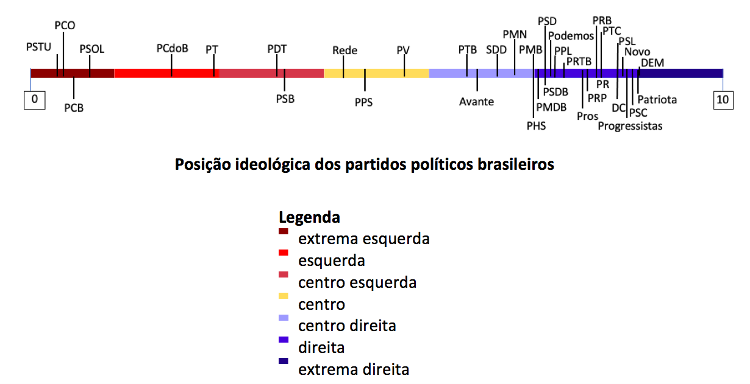

In [28]:
from IPython.display import Image
Image("./espectro1.png")

Fonte: UOL (https://noticias.uol.com.br/colunas/observatorio-das-eleicoes/2020/11/24/esquerda-centro-ou-direita-como-classificar-os-partidos-no-brasil.htm)

Analisar dados de duas eleições deixou claro dois fatos sobre os partidos políticos e seus posicionamentos no espectro político:

1) A prática de mudança de nome de partido/sigla é muito mais comum do que eu imaginava. Entre 2016 e 2020, alguns exemplos de mudança de nomes de partidos: PRB virou Republicanos; PMDB virou MDB; AVANTE é o antigo PT do B; PPS virou Cidadania, entre (diversos) outros.

2) Essa análise fará a categorização dos partidos entre "esquerda" e "direita", apenas. Pode-se considerar simplista esta análise, principalmente se comparada à imagem acima que gerou 7 categorizações, mas este é um exemplo de situação que ilustra que trabalhar com dados nem sempre é preto no branco: hipóteses / suposições muitas vezes são feitas. O importante é que se deixe claro para o leitor as decisões que foram tomadas. Para o caso de Jundiaí o espectro do UOL acima funciona muito bem. Uma dúvida surgiu com relação aos 3 partidos na faixa amarela: Rede, PPS e PV. Mas analisando-se as alianças históricas feitas por estes partidos na cidades, bem como a orientação de votações em pautas da câmara decidiu-se por classificá-los como partidos de direita


In [29]:
direita = ["PSL", "PRP", "PR", "PRB", "PMDB", "MDB", "PTB", "PP", "DEM", "SD", "PSD", 
           "PHS", "PODE", "PSC", "PSDB", "PEN", "PPS", "PRTB", "NOVO", 'REPUBLICANOS',"AVANTE","PRP",
          "PROS","PPL","PMN","PSDC","PTN","PTC", "DC", "PL","PPS", "PV"]

In [30]:
esquerda = ["PDT", "PT", "PSOL","PC do B", "PSB", "PSTU", "PCO", "PCB", "REDE", "CIDADANIA","SOLIDARIEDADE"]

In [31]:
df_jund["POSIC"] = ["DIREITA" if x in direita else "ESQUERDA" for x in df_jund["SG_PARTIDO"]]


<ipython-input-31-b0036346d121>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jund["POSIC"] = ["DIREITA" if x in direita else "ESQUERDA" for x in df_jund["SG_PARTIDO"]]


In [32]:
df_jund[df_jund["POSIC"] == "ESQUERDA"].SG_PARTIDO.unique()

array(['PSB', 'PC do B', 'PT', 'PDT', 'PSOL', 'CIDADANIA',
       'SOLIDARIEDADE', 'REDE'], dtype=object)

In [33]:
df_jund_2020 = df_jund[df_jund["ANO_ELEICAO"] == 2020]

In [34]:
print("Havia {} partidos de esquerda nas eleições para vereador em Jundiaí em 2020".format(len(df_jund_2020[df_jund_2020["POSIC"] == "ESQUERDA"].SG_PARTIDO.unique())))

Havia 8 partidos de esquerda nas eleições para vereador em Jundiaí em 2020


In [35]:
df_jund[df_jund["POSIC"] == "DIREITA"].SG_PARTIDO.unique()

array(['PROS', 'PV', 'PSDB', 'PRB', 'PSD', 'PP', 'PTB', 'PEN', 'PPS',
       'PSDC', 'PMDB', 'PR', 'PHS', 'DEM', 'PSC', 'SD', 'PTN', 'PRP',
       'PPL', 'PTC', 'NOVO', 'PODE', 'REPUBLICANOS', 'PSL', 'AVANTE',
       'DC', 'PL', 'PRTB'], dtype=object)

In [36]:
print("Havia {} partidos de direita nas eleições para vereador em Jundiaí em 2020".format(len(df_jund_2020[df_jund_2020["POSIC"] == "DIREITA"].SG_PARTIDO.unique())))

Havia 15 partidos de direita nas eleições para vereador em Jundiaí em 2020


In [37]:
df_jund["DS_SIT_TOT_TURNO"].unique()

array(['SUPLENTE', 'NÃO ELEITO', 'ELEITO POR MÉDIA', 'ELEITO POR QP',
       'ELEITO', '2º TURNO'], dtype=object)

In [38]:
df_jund["TP_AGREMIACAO"].unique()

array(['Partido isolado', 'Coligação'], dtype=object)

In [39]:
df_jund["NM_COLIGACAO"].unique()

array(['PARTIDO ISOLADO', 'JUNTOS POR UMA JUNDIAÍ CADA VEZ MELHOR',
       'ESPERANÇA RENOVADA PTB/PRP', 'JUNDIAI: QUEM AMA CUIDA',
       'JUNTOS PARA FAZER AINDA MAIS', 'PR - PTN', 'PHS - PDT',
       'JUNTOS, TUDO É POSSÍVEL', 'AGORA É A VEZ DO FUTURO',
       'PRA JUNDIAÍ SEGUIR EM FRENTE', 'JUNTOS PODEMOS MAIS',
       'JUNDIAÍ CIDADE PARA TODOS ', 'JUNDIAÍ EM 1. LUGAR'], dtype=object)

In [40]:
# As informações sobre os tipos de variáveis e análise sobre quais dropar foram feitas no excel chamado "df_jund"
df_jund.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2577 entries, 2876 to 219427
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DT_GERACAO                2577 non-null   object
 1   HH_GERACAO                2577 non-null   object
 2   ANO_ELEICAO               2577 non-null   int64 
 3   CD_TIPO_ELEICAO           2577 non-null   int64 
 4   NM_TIPO_ELEICAO           2577 non-null   object
 5   NR_TURNO                  2577 non-null   int64 
 6   CD_ELEICAO                2577 non-null   int64 
 7   DS_ELEICAO                2577 non-null   object
 8   DT_ELEICAO                2577 non-null   object
 9   TP_ABRANGENCIA            2577 non-null   object
 10  SG_UF                     2577 non-null   object
 11  SG_UE                     2577 non-null   int64 
 12  NM_UE                     2577 non-null   object
 13  CD_MUNICIPIO              2577 non-null   int64 
 14  NM_MUNICIPIO       

In [41]:
to_drop = ["DT_GERACAO", "HH_GERACAO", "CD_TIPO_ELEICAO", "DS_ELEICAO", "TP_ABRANGENCIA", "SG_UE", "SQ_CANDIDATO",
          "NM_SOCIAL_CANDIDATO", "NM_PARTIDO", "SQ_COLIGACAO", "ST_VOTO_EM_TRANSITO", "NR_TURNO"]

# NR_TURNO está sendo desconsiderada pois iremos focar a análise na eleição a vereador, apenas

In [42]:
#Dropando as colunas e focando na eleição a vereador

df_jund = df_jund.drop(to_drop, axis = 1)
df_jund = df_jund[df_jund["CD_CARGO"] == 13]
df_jund.head()

,ANO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DT_ELEICAO,SG_UF,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,CD_CARGO,DS_CARGO,NR_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,CD_DETALHE_SITUACAO_CAND,DS_DETALHE_SITUACAO_CAND,TP_AGREMIACAO,NR_PARTIDO,SG_PARTIDO,NM_COLIGACAO,DS_COMPOSICAO_COLIGACAO,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,POSIC
2876,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,281,13,Vereador,40040,OSVALDO CASCAIS SANTOS,DIVA (OSVALDO CASCAIS),12,APTO,2,DEFERIDO,Partido isolado,40,PSB,PARTIDO ISOLADO,PSB,5,SUPLENTE,22,ESQUERDA
2877,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,281,13,Vereador,40412,DENILCE JOSEFINA NICOLA,DENILCE NICOLA,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,PARTIDO ISOLADO,PSB,5,SUPLENTE,108,ESQUERDA
2878,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,65,13,Vereador,40333,LUZIA BRIGONI,LUZIA BRIGONI,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,PARTIDO ISOLADO,PSB,5,SUPLENTE,7,ESQUERDA
2879,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,424,13,Vereador,40412,DENILCE JOSEFINA NICOLA,DENILCE NICOLA,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,PARTIDO ISOLADO,PSB,5,SUPLENTE,35,ESQUERDA
2880,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,424,13,Vereador,90252,MARIA VALÉRIA BULHOES CARNEIRO,VALÉRIA BULHÕES,12,APTO,2,DEFERIDO,Partido isolado,90,PROS,PARTIDO ISOLADO,PROS,5,SUPLENTE,32,DIREITA


### Situação da candidatura

https://www.tse.jus.br/imprensa/noticias-tse/2020/Setembro/eleicoes-2020-sistema-de-divulgacao-de-candidaturas-ja-esta-disponivel-1

São três os principais termos utilizados na ferramenta. Quando o processo é registrado na Justiça Eleitoral, é informada a palavra “cadastrado” e, em seguida, “aguardando julgamento”. Isso significa que o candidato enviou o pedido de registro de candidatura, mas o pedido ainda não foi julgado, ou seja, o processo está tramitando e aguarda análise.

Após o processo ser apreciado pela Justiça Eleitoral, o registro pode ser considerado “apto” ou “inapto”. Caso o candidato preencha todas as condições de elegibilidade, isto é, não tenha nenhuma contestação e o pedido tenha sido acatado, a situação que aparecerá no sistema será “apto” e “deferido”.

Outro caso é quando o candidato aparece como apto, mas houve impugnações e a decisão é no sentido de negar o registro. Nesse caso, a situação será “apto”, e o complemento será “indeferido com recurso”.

Por outro lado, existe o caso do candidato que apresentou o registro, e as condições de elegibilidade avaliadas foram deferidas pelo juiz; contudo, o Ministério Público Eleitoral (MPE) ou o partido recorreu da decisão. Nessa hipótese, a condição será “apto” e “deferido com recurso”.

Na situação de registro julgado como apto, ainda existem as possibilidades de “cassado com recurso” ou “cancelado com recurso”. Isso ocorre quando o candidato teve o registro cassado ou cancelado pelo partido ou por decisão judicial, porém apresentou recurso e aguarda uma nova decisão.

Por fim, também consta do sistema a condição de “inapto”, com os complementos: “cancelado”, quando o candidato teve o registro cancelado pelo partido; “cassado”; “falecido”; “indeferido”, quando o candidato não reuniu as condições necessárias ao registro; “não conhecimento do pedido”, candidato cujo o pedido de registro não foi apreciado pelo juiz eleitoral; e “renúncia”.

In [43]:
# Analisando as candiaturas aptas em Jundiai
df_jund[df_jund["CD_SITUACAO_CANDIDATURA"] == 12]["DS_DETALHE_SITUACAO_CAND"].unique()

array(['DEFERIDO', 'INDEFERIDO COM RECURSO'], dtype=object)

In [44]:
# Verifica-se que há candidaturas que foram impugnadas após serem consideradas aptas - iremos filtrá-las

df_jund = df_jund[df_jund["CD_SITUACAO_CANDIDATURA"] == 12]
df_jund = df_jund[df_jund["CD_DETALHE_SITUACAO_CAND"] == 2]
df_jund.head()

,ANO_ELEICAO,NM_TIPO_ELEICAO,CD_ELEICAO,DT_ELEICAO,SG_UF,NM_UE,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,CD_CARGO,DS_CARGO,NR_CANDIDATO,NM_CANDIDATO,NM_URNA_CANDIDATO,CD_SITUACAO_CANDIDATURA,DS_SITUACAO_CANDIDATURA,CD_DETALHE_SITUACAO_CAND,DS_DETALHE_SITUACAO_CAND,TP_AGREMIACAO,NR_PARTIDO,SG_PARTIDO,NM_COLIGACAO,DS_COMPOSICAO_COLIGACAO,CD_SIT_TOT_TURNO,DS_SIT_TOT_TURNO,QT_VOTOS_NOMINAIS,POSIC
2876,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,281,13,Vereador,40040,OSVALDO CASCAIS SANTOS,DIVA (OSVALDO CASCAIS),12,APTO,2,DEFERIDO,Partido isolado,40,PSB,PARTIDO ISOLADO,PSB,5,SUPLENTE,22,ESQUERDA
2877,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,281,13,Vereador,40412,DENILCE JOSEFINA NICOLA,DENILCE NICOLA,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,PARTIDO ISOLADO,PSB,5,SUPLENTE,108,ESQUERDA
2878,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,65,13,Vereador,40333,LUZIA BRIGONI,LUZIA BRIGONI,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,PARTIDO ISOLADO,PSB,5,SUPLENTE,7,ESQUERDA
2879,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,424,13,Vereador,40412,DENILCE JOSEFINA NICOLA,DENILCE NICOLA,12,APTO,2,DEFERIDO,Partido isolado,40,PSB,PARTIDO ISOLADO,PSB,5,SUPLENTE,35,ESQUERDA
2880,2016,Eleição Ordinária,220,02/10/2016,SP,JUNDIAÍ,66192,JUNDIAÍ,424,13,Vereador,90252,MARIA VALÉRIA BULHOES CARNEIRO,VALÉRIA BULHÕES,12,APTO,2,DEFERIDO,Partido isolado,90,PROS,PARTIDO ISOLADO,PROS,5,SUPLENTE,32,DIREITA


In [45]:
#d = df_jund.groupby(["ANO_ELEICAO",'POSIC'])["QT_VOTOS_NOMINAIS"].sum().reset_index()
d = df_jund.groupby(["ANO_ELEICAO",'POSIC'])["QT_VOTOS_NOMINAIS"].sum().reset_index()

In [46]:
d

,ANO_ELEICAO,POSIC,QT_VOTOS_NOMINAIS
0,2016,DIREITA,160035
1,2016,ESQUERDA,27100
2,2020,DIREITA,150158
3,2020,ESQUERDA,31766


In [47]:
d["PERCENT"] = 0

In [48]:
perc = []
a1 = d.loc[0][2] / (d.loc[0][2] + d.loc[1][2]) * 100
perc.append(a1)
a1 = d.loc[1][2] / (d.loc[0][2] + d.loc[1][2]) * 100
perc.append(a1)
a1 = d.loc[2][2] / (d.loc[2][2] + d.loc[3][2]) * 100
perc.append(a1)
a1 = d.loc[3][2] / (d.loc[2][2] + d.loc[3][2]) * 100
perc.append(a1)

In [49]:
perc

[85.51847596654821, 14.481524033451787, 82.53886238209363, 17.461137617906378]

In [50]:
d["PERCENT"] = perc
d = d.round(3)

In [51]:
d

,ANO_ELEICAO,POSIC,QT_VOTOS_NOMINAIS,PERCENT
0,2016,DIREITA,160035,85.518
1,2016,ESQUERDA,27100,14.482
2,2020,DIREITA,150158,82.539
3,2020,ESQUERDA,31766,17.461


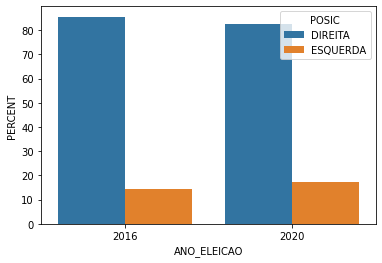

In [52]:
ax = sns.barplot(x="ANO_ELEICAO", y="PERCENT", hue = "POSIC", data=d)

Levando-se em conta a expressiva votação de Luiz Fernando Machado para prefeito (eleito em primeiro turno com 69,64% de votos pelo PSDB) e que o percentual de votos em partidos de direita é bem maior do que em partidos de esquerda (ao redor de 80% contra 20%) é bastante claro que a maioria dos eleitores de Jundiaí é de direita; o alento para a esquerda jundiaiense é o aumento  de 3% (ainda que baixo) no percentual de votos para vereadores de siglas mais à esquerda.

#### Consolidando os votos por partido e analisando os 10 partidos mais votados

In [53]:
h = df_jund.groupby(['ANO_ELEICAO', 'SG_PARTIDO', 'DS_COMPOSICAO_COLIGACAO'])[df_jund.columns[df_jund.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = ['ANO_ELEICAO', 'QT_VOTOS_NOMINAIS'], ascending = False).reset_index()

h["POSIC"] = ["DIREITA" if x in direita else "ESQUERDA" for x in h["SG_PARTIDO"]]

h[h["ANO_ELEICAO"] == 2020].head(10)

,ANO_ELEICAO,SG_PARTIDO,DS_COMPOSICAO_COLIGACAO,QT_VOTOS_NOMINAIS,POSIC
0,2020,PL,PL,41100,DIREITA
1,2020,PP,PP,21243,DIREITA
2,2020,DEM,DEM,20409,DIREITA
3,2020,PSDB,PSDB,18109,DIREITA
4,2020,PSC,PSC,13325,DIREITA
5,2020,PTB,PTB,8557,DIREITA
6,2020,REPUBLICANOS,REPUBLICANOS,7593,DIREITA
7,2020,PSOL,PSOL,6117,ESQUERDA
8,2020,PODE,PODE,5626,DIREITA
9,2020,PSB,PSB,5184,ESQUERDA


In [54]:
h[h["ANO_ELEICAO"] == 2016].head(10)

,ANO_ELEICAO,SG_PARTIDO,DS_COMPOSICAO_COLIGACAO,QT_VOTOS_NOMINAIS,POSIC
23,2016,PSDB,PSDB,21665,DIREITA
24,2016,PR,PR / PTN,17301,DIREITA
25,2016,PSD,PSD / PRB / PP,14514,DIREITA
26,2016,PV,PV,14075,DIREITA
27,2016,PTB,PTB / PRP,13549,DIREITA
28,2016,PROS,PROS,12186,DIREITA
29,2016,PPS,PPS / PEN,11698,DIREITA
30,2016,PSB,PSB,11691,ESQUERDA
31,2016,PHS,PHS / PDT,11366,DIREITA
32,2016,PP,PSD / PRB / PP,9161,DIREITA


Notas: 

Acabaram as coligações?

PL (antigo PR) mais que dobrou a quantidade de votos em veredores. Deve-se notar um fato importante que serve de explicação: o PV não teve candidatos para vereador, e este é um partido com forte influência em eleição para vereadores (quarto partido com mais votos em 2016). Nomes importantes desta sigla migraram para o PL, como por exemplo Leandro Palmarini (Bicho Legal)

PT e PSDB apresentaram a mesma tendência que em muitas das cidades a nível nacional, de queda no número de votos; PSOL, por outro lado, teve um crescimento expressivo

## Analisando a eleição de 2016 individualmente

In [55]:
#Consolidação dos votos por vereador em 2016
df_jundiai_2016 = df_jund[df_jund['ANO_ELEICAO'] == 2016]
df_jundiai_2016.groupby(['NM_URNA_CANDIDATO'])[df_jundiai_2016.columns[df_jundiai_2016.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = 'QT_VOTOS_NOMINAIS', ascending = False)





,QT_VOTOS_NOMINAIS
NM_URNA_CANDIDATO,
GUSTAVO MARTINELLI,7217
LEANDRO PALMARINI -BICHO LEGAL,4331
DR. LIGABÓ,4036
PAULO SERGIO MARTINS-DELEGADO,3855
MARCELO GASTALDO,3321
...,...
ROSE TORRES,6
MARTA BONILHA,5
DAIANE PORTO,4


In [56]:
columns = ['QT_VOTOS_NOMINAIS', 'SG_PARTIDO']

In [57]:
df_jundiai_2016.groupby(['NM_URNA_CANDIDATO', 'NR_ZONA'])[df_jundiai_2016.columns[df_jundiai_2016.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = 'QT_VOTOS_NOMINAIS', ascending = False)

,,QT_VOTOS_NOMINAIS
NM_URNA_CANDIDATO,NR_ZONA,
GUSTAVO MARTINELLI,281,5834
DIKA XIQUE-XIQUE,281,2796
ROGERIO,281,2398
ROMILDO ANTONIO,65,2244
MARCELO GASTALDO,65,2127
...,...,...
DAIANE PORTO,424,0
MARTA BONILHA,65,0
ROSE TORRES,424,0


In [58]:
g = df_jundiai_2016.groupby(['NM_URNA_CANDIDATO', 'NR_ZONA'])[df_jundiai_2016.columns[df_jundiai_2016.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = ['NM_URNA_CANDIDATO', "NR_ZONA"])

In [59]:
g = g.reset_index().pivot('NR_ZONA','NM_URNA_CANDIDATO')
g

QT_VOTOS_NOMINAIS                                       \
NM_URNA_CANDIDATO   ADALBERTO MICAI ADALCIO CORREDOR ADEMIR PEDRO VICTOR   
NR_ZONA                                                                    
65                               26                7                 153   
281                             138              103                 380   
424                              63                6                 367   

                                                                              \
NM_URNA_CANDIDATO ADILSON MANAZZERO (MAGOO) ADILTON GARCIA ADRIANA  MÁQUINA    
NR_ZONA                                                                        
65                                        4            411                10   
281                                      35           1047                56   
424                                       7            258                 8   

                                                                            \
NM_URNA_CANDIDATO ADRIANA TORRES ALBINO ALESSANDRO PAVANI ALESSANDRO PEREZ   
NR_ZONA                                                                      
65                             1    639                61               35   
281                           22   1440               288               99   
424                            4    266               448               71   

                                                                           \
NM_URNA_CANDIDATO ALINE PADILHA ALTEVIR CECCATO AMARILDO SALMISTA AMELIAN   
NR_ZONA                                                                     
65                            7              27                36     237   
281                          24             147                63      35   
424                          25              84               501      20   

                                                                            \
NM_URNA_CANDIDATO ANA LUCIA DO BARAO ANA MASO ANA REGINA ANA TONELLI ANALU   
NR_ZONA                                                                      
65                                 0       98         15         281     5   
281                               21       69         59         676    16   
424                                1       26         66         524     2   

                                                                       \
NM_URNA_CANDIDATO ANDRE CANTONI ANDRE OLIVEIRA ANDREIA APARECIDA NEGA   
NR_ZONA                                                                 
65                           62              6                      9   
281                         269              3                      7   
424                          47             12                     13   

                                                                    \
NM_URNA_CANDIDATO ANDREIA DEZOTI ANDRÉ DA AMBULÂNCIA ANGEL CAROLLA   
NR_ZONA                                                              
65                            22                  31            10   
281                            8                  42            95   
424                            8                  58            23   

                                                                 \
NM_URNA_CANDIDATO ANGELA LIMA ARNALDO DA FARMÁCIA ARNOON FREIRE   
NR_ZONA                                                           
65                         42                1651             6   
281                         7                 258             9   
424                         8                 275            41   

                                                                          \
NM_URNA_CANDIDATO ARTHUR AUGUSTO BARBA PARANÁ BARBAN BENE COELHO BERNINI   
NR_ZONA                                                                    
65                            43           29    106         267     241   
281                           83           13    190          28     756   
424                           77    

In [60]:
g[('QT_VOTOS_NOMINAIS','ADALBERTO MICAI')].iloc[0]

26

In [61]:
pd.set_option("display.max_rows", df_jundiai_2016.index.shape[0])
df_jundiai_2016.groupby(['NR_ZONA', 'NM_URNA_CANDIDATO'])[df_jundiai_2016.columns[df_jundiai_2016.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = ['NR_ZONA', 'QT_VOTOS_NOMINAIS'], ascending = False)

QT_VOTOS_NOMINAIS
NR_ZONA NM_URNA_CANDIDATO                                
424     MARCIO CABELEIREIRO                          1647
        DR. LIGABÓ                                   1619
        PAULO SERGIO MARTINS-DELEGADO                1503
        ZÉ DIAS                                      1387
        LEANDRO PALMARINI -BICHO LEGAL               1360
        MARCO BOMBA                                  1146
        CRISTIANO LOPES                              1089
        GUSTAVO MARTINELLI                            906
        ELTON IENNE                                   879
        PAULO MALERBA                                 826
        DOUGLAS MEDEIROS                              782
        IRMÃO DA LOJINHA                              718
        VALDECI DELANO                                671
        PASTOR ROBERTO CONDE                          643
        CICERO DA SAÚDE                               641
        PASTOR DIRLEI                                 628
        FAOUAZ TAHA                                   615
        DR. CLAUDIO MIRANDA                           559
        ILCEMAR FONSECA                               553
        MARCELO GASTALDO                              528
        ANA TONELLI                                   524
        GUSTAVO CHECCHINATO                           514
        MARCOS BRUNHOLI                               513
        EURICO                                        504
        AMARILDO SALMISTA                             501
        TONINHO AMARAL                                485
        KACHAN                                        473
        GERSON SARTORI                                472
        MARCELO CANALE                                469
        ALESSANDRO PAVANI                             448
        BERNINI                                       430
        NELSON CREPALDI                               401
        CORONEL FACCHINI                              392
        CELSO L. ARANTES                              369
        ADEMIR PEDRO VICTOR                           367
        TANIA BUENO                                   363
        ENRICO  MILAMONTI                             348
        DRA. SILVANA                                  334
        JULIÃO                                        332
        NÁDIA TAFFARELLO                              329
        RAFAEL TINTAS COLONIA                         307
        MAIRA                                         304
        CLAUDEMIR MORAES                              302
        DR. VIDAL                                     296
        JOÃO CARLOS LOPES                             292
        PROF. RAFAEL PURGATO                          285
        ARNALDO DA FARMÁCIA                           275
        ROGERIO                                       275
        RENATA DO BAR                                 273
        GLAUCO GIULIANO                               272
        JOSÉ CARLOS (CARLINHOS)                       270
        ALBINO                                        266
        MOACIR BIAZIM                                 266
        SONIA CECATO                                  263
        TIÃO PRETO                                    262
        NICOLAI                                       260
        ADILTON GARCIA                                258
        PROTETORA IVANETE                             252
        DIEGO SILVA                                   231
        ROGÉRIO CODARIN                               227
        DR. WANDERLEI                                 222
        JONES MARTINS                                 222
        CASCÃO                                        220
        PROFESSORA LEILA                              198
        PEDRINHO                                      197
        TÉRCIO MARINHO                                196
        NELSINHO JAMAICA                              195
        SERGINHO VIDROS               

In [62]:
pd.set_option("display.max_rows", df_jundiai_2016.index.shape[0])
w = df_jundiai_2016.groupby(['NR_ZONA', 'NM_URNA_CANDIDATO'])[df_jundiai_2016.columns[df_jundiai_2016.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = ['NR_ZONA', 'QT_VOTOS_NOMINAIS'], ascending = False)

w.groupby('NR_ZONA').head(10)


QT_VOTOS_NOMINAIS
NR_ZONA NM_URNA_CANDIDATO                                
424     MARCIO CABELEIREIRO                          1647
        DR. LIGABÓ                                   1619
        PAULO SERGIO MARTINS-DELEGADO                1503
        ZÉ DIAS                                      1387
        LEANDRO PALMARINI -BICHO LEGAL               1360
        MARCO BOMBA                                  1146
        CRISTIANO LOPES                              1089
        GUSTAVO MARTINELLI                            906
        ELTON IENNE                                   879
        PAULO MALERBA                                 826
281     GUSTAVO MARTINELLI                           5834
        DIKA XIQUE-XIQUE                             2796
        ROGERIO                                      2398
        LEANDRO PALMARINI -BICHO LEGAL               2090
        ZÉ ADAIR                                     1847
        DR. LIGABÓ                                   1774
        PAULO MALERBA                                1709
        PAULO SERGIO MARTINS-DELEGADO                1599
        PASTOR DIRLEI                                1547
        ALBINO                                       1440
65      ROMILDO ANTONIO                              2244
        MARCELO GASTALDO                             2127
        EDICARLOS DO VETOR OESTE                     1988
        ARNALDO DA FARMÁCIA                          1651
        TIA GRAÇA                                     943
        PROFESSOR ELIEZER                             935
        VALDECI DELANO                                910
        LEANDRO PALMARINI -BICHO LEGAL                881
        PASTOR DIRLEI                                 795
        PAULO SERGIO MARTINS-DELEGADO                 753

In [63]:
df_jundiai_2016.groupby(['NR_ZONA'])[df_jundiai_2016.columns[df_jundiai_2016.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = 'QT_VOTOS_NOMINAIS', ascending = False)

,QT_VOTOS_NOMINAIS
NR_ZONA,
281,91105
424,48208
65,47822


## Analisando a eleição de 2020 individualmente

In [64]:
#Consolidação dos votos por vereador em 2016
df_jundiai_2020 = df_jund[df_jund['ANO_ELEICAO'] == 2020]
df_jundiai_2020.groupby(['NM_URNA_CANDIDATO'])[df_jundiai_2020.columns[df_jundiai_2020.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = 'QT_VOTOS_NOMINAIS', ascending = False)



,QT_VOTOS_NOMINAIS
NM_URNA_CANDIDATO,
ALBINO,7345
EDICARLOS VIEIRA VETOR OESTE,5439
DIKA XIQUE XIQUE,4662
HENRIQUE PARRA DO CARDUME,4256
CRISTIANO LOPES,3533
FAOUAZ TAHA,3351
ROMILDO ANTONIO,3348
DR LIGABÓ,3212
MADSON HENRIQUE,3052


In [65]:
df_jundiai_2020.groupby(['NM_URNA_CANDIDATO', 'NR_ZONA'])[df_jundiai_2020.columns[df_jundiai_2020.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = 'QT_VOTOS_NOMINAIS', ascending = False)

,,QT_VOTOS_NOMINAIS
NM_URNA_CANDIDATO,NR_ZONA,
EDICARLOS VIEIRA VETOR OESTE,65,4795
DIKA XIQUE XIQUE,281,4190
ALBINO,281,4169
ROMILDO ANTONIO,65,2846
ALBINO,65,2521
...,...,...
DR MAIA,65,0
NEIDE,65,0
DR MAIA,424,0


In [66]:
pd.set_option("display.max_rows", df_jundiai_2020.index.shape[0])
w = df_jundiai_2020.groupby(['NR_ZONA', 'NM_URNA_CANDIDATO','SG_PARTIDO'])[df_jundiai_2020.columns[df_jundiai_2020.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = ['NR_ZONA', 'QT_VOTOS_NOMINAIS'], ascending = False)

w.groupby('NR_ZONA').head(5)

QT_VOTOS_NOMINAIS
NR_ZONA NM_URNA_CANDIDATO            SG_PARTIDO                   
424     CRISTIANO LOPES              PP                       1854
        HENRIQUE PARRA DO CARDUME    PSOL                     1469
        MARCO BOMBA                  DEM                      1363
        DR LIGABÓ                    CIDADANIA                1258
        FAOUAZ TAHA                  PSDB                     1166
281     DIKA XIQUE XIQUE             PL                       4190
        ALBINO                       PL                       4169
        DANIEL LEMOS                 DEM                      1987
        HENRIQUE PARRA DO CARDUME    PSOL                     1953
        ROGERIO                      DEM                      1893
65      EDICARLOS VIEIRA VETOR OESTE PP                       4795
        ROMILDO ANTONIO              PL                       2846
        ALBINO                       PL                       2521
        TIAGO DA EL ELION            PSC                      1279
        MARCELO  GASTALDO            PTB                      1268

In [67]:
df_jundiai_2020.groupby(['NR_ZONA'])[df_jundiai_2020.columns[df_jundiai_2020.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = 'QT_VOTOS_NOMINAIS', ascending = False)

,QT_VOTOS_NOMINAIS
NR_ZONA,
281,87546
65,48960
424,45418


In [68]:
candidato = "HENRIQUE PARRA DO CARDUME"

In [69]:
df_jundiai_2020_HP = df_jundiai_2020[df_jundiai_2020["NM_URNA_CANDIDATO"] == candidato]

In [70]:
df_jundiai_2020_HP.groupby(['NR_ZONA'])[df_jundiai_2020_HP.columns[df_jundiai_2020_HP.columns == 'QT_VOTOS_NOMINAIS']].sum().sort_values(by = 'QT_VOTOS_NOMINAIS', ascending = False).reset_index()




,NR_ZONA,QT_VOTOS_NOMINAIS
0,281,1953
1,424,1469
2,65,834


### Plotando quantidade de votos no mapa

In [71]:
#Votos por bairro do candidado Henrique Parra
df_bairros = pd.read_excel('BAIRRO_RESUMO_V02.xls', sheet_name = 1)

In [72]:
#Shapefile das zonas eleitorais do estado de são paulo
teste = gpd.read_file("./SP_ZONAS_janeiro_2018/ZONAS_FINAL.shp")

In [73]:
teste[teste["FIRST_NOME"] == "JUNDIAÍ"].head(50)

,OBJECTID,ZEFINAL,FIRST_sede,FIRST_NOME,Shape_Leng,Shape_Area,geometry
63,64,65,JUNDIAÍ,JUNDIAÍ,0.884576,0.025165,"POLYGON ((-47.04599 -23.05272, -47.04526 -23.0..."
261,262,281,JUNDIAÍ,JUNDIAÍ,1.043799,0.021550,"POLYGON ((-46.80779 -23.14666, -46.80748 -23.1..."
390,391,424,JUNDIAÍ,JUNDIAÍ,0.553097,0.009025,"POLYGON ((-46.85676 -23.08290, -46.85618 -23.0..."


In [74]:
plotdata = teste[teste['FIRST_NOME'].isin(['JUNDIAÍ','VÁRZEA PAULISTA','CAMPO LIMPO PAULISTA','ITUPEVA', "LOUVEIRA"])]

In [75]:
#Inserindo votos do candidato Henrique Parra no dataframe
plotdata["Candidato1"] = 0
plotdata["Candidato1"].iloc[0] = 834
plotdata["Candidato1"].iloc[2] = 1953 
plotdata["Candidato1"].iloc[4] = 1469
plotdata['coords'] = plotdata['geometry'].apply(lambda x: x.centroid.coords[:])
plotdata['coords'] = [coords[0] for coords in plotdata['coords']]

plotdata

/Users/lucasmaretti/opt/anaconda3/envs/ox/lib/python3.9/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/lucasmaretti/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-75-66d621dd6546>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

,OBJECTID,ZEFINAL,FIRST_sede,FIRST_NOME,Shape_Leng,Shape_Area,geometry,Candidato1,coords
63,64,65,JUNDIAÍ,JUNDIAÍ,0.884576,0.025165,"POLYGON ((-47.04599 -23.05272, -47.04526 -23.0...",834,"(-47.03857714751748, -23.148655629412286)"
223,224,242,VÁRZEA PAULISTA,VÁRZEA PAULISTA,0.282427,0.003098,"POLYGON ((-46.82121 -23.18179, -46.82096 -23.1...",0,"(-46.824908570373005, -23.219272436251533)"
261,262,281,JUNDIAÍ,JUNDIAÍ,1.043799,0.021550,"POLYGON ((-46.80779 -23.14666, -46.80748 -23.1...",1953,"(-46.91244815317335, -23.234855566279172)"
314,315,344,CAMPO LIMPO PAULISTA,CAMPO LIMPO PAULISTA,0.434284,0.007005,"POLYGON ((-46.78614 -23.15369, -46.78616 -23.1...",0,"(-46.760056482055354, -23.21791797692079)"
390,391,424,JUNDIAÍ,JUNDIAÍ,0.553097,0.009025,"POLYGON ((-46.85676 -23.08290, -46.85618 -23.0...",1469,"(-46.86910301365951, -23.132251593526732)"


In [76]:
geo_jund = plotdata[plotdata["FIRST_NOME"] == "JUNDIAÍ"]

In [77]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="openstreetmap")

In [78]:
location = geolocator.geocode("Vila Arens, Jundiaí, São Paulo")
print((location.latitude, location.longitude))

(-23.1989846, -46.8774198)


In [79]:
def endjund(bairro):
    return bairro +', Jundiaí, São Paulo'

In [80]:
df_bairros['Endereco'] = endjund(df_bairros['BAIRRO'])

In [81]:
df_bairros.head(10)

,VOTOS RECEBIDOS,BAIRRO,Zona,Seção,Endereco
0,392,VILA ARENS II,281,15,"VILA ARENS II, Jundiaí, São Paulo"
1,257,VILA VIANELO,424,209,"VILA VIANELO, Jundiaí, São Paulo"
2,239,CENTRO,424,76,"CENTRO, Jundiaí, São Paulo"
3,224,VILA DAS HORTÊNCIAS,65,528,"VILA DAS HORTÊNCIAS, Jundiaí, São Paulo"
4,198,ANHANGABAÚ,424,19,"ANHANGABAÚ, Jundiaí, São Paulo"
5,138,VILA VIRGÍNIA,424,58,"VILA VIRGÍNIA, Jundiaí, São Paulo"
6,127,JARDIM PAULISTA,424,260,"JARDIM PAULISTA, Jundiaí, São Paulo"
7,125,VILA MARLENE,65,310,"VILA MARLENE, Jundiaí, São Paulo"
8,118,JARDIM PACAEMBU,281,298,"JARDIM PACAEMBU, Jundiaí, São Paulo"
9,118,VILA RIO BRANCO,424,144,"VILA RIO BRANCO, Jundiaí, São Paulo"


In [82]:
#Funções para inserir coordenadas de latitude e longitude no dataframe com base no openstreet map do pacote geopy

def get_lat_lon(x):
    try:
        location = geolocator.geocode(x)
        return (location.longitude, location.latitude)
    except: return (0, 0)
    
def get_lat(x):
    try:
        location = geolocator.geocode(x)
        return location.latitude
    except: return 0
    
def get_lon(x):
    try:
        location = geolocator.geocode(x)
        return location.longitude
    except: return 0

In [83]:
df_bairros['Lat_long'] = df_bairros["Endereco"].apply(lambda x: get_lat_lon(x))
df_bairros['Latitude'] = df_bairros["Endereco"].apply(lambda x: get_lat(x))
df_bairros['Longitude'] = df_bairros["Endereco"].apply(lambda x: get_lon(x))

In [84]:
df_bairros.head()

,VOTOS RECEBIDOS,BAIRRO,Zona,Seção,Endereco,Lat_long,Latitude,Longitude
0,392,VILA ARENS II,281,15,"VILA ARENS II, Jundiaí, São Paulo","(-46.8774198, -23.1989846)",-23.198985,-46.877420
1,257,VILA VIANELO,424,209,"VILA VIANELO, Jundiaí, São Paulo","(-46.8829257, -23.1976488)",-23.197649,-46.882926
2,239,CENTRO,424,76,"CENTRO, Jundiaí, São Paulo","(-46.950868, -23.0882759)",-23.088276,-46.950868
3,224,VILA DAS HORTÊNCIAS,65,528,"VILA DAS HORTÊNCIAS, Jundiaí, São Paulo","(-46.9153883, -23.1813954)",-23.181395,-46.915388
4,198,ANHANGABAÚ,424,19,"ANHANGABAÚ, Jundiaí, São Paulo","(-46.8937772, -23.1931207)",-23.193121,-46.893777


In [85]:
import osmnx as ox
import geopandas as gpd

from shapely.geometry import Point

city = ox.geocode_to_gdf('Jundiaí, São Paulo, Brasil')

<AxesSubplot:>

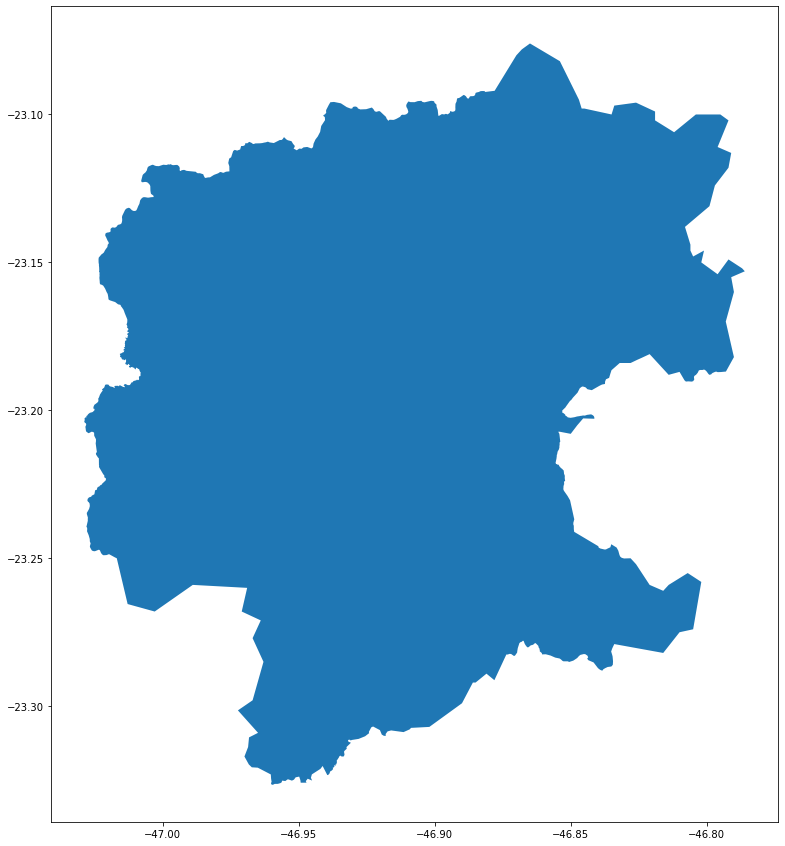

In [86]:
fig, ax = plt.subplots(figsize=(15, 15))
city.plot(ax=ax)

In [87]:
#We transform the coordinates tuples into a Point, an object that will make it easy to do geospatial operations.

df_bairros["geometry"] = df_bairros["Lat_long"].apply(lambda x : Point(x))

In [88]:
geo_df = gpd.GeoDataFrame(df_bairros, crs={"init": "epsg:4326"}, geometry=df_bairros["geometry"])

/Users/lucasmaretti/opt/anaconda3/envs/ox/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [89]:
exclude_data = geo_df[geo_df["Lat_long"] >= (0, 0)]["Lat_long"].unique()
geo_df = geo_df[~geo_df["Lat_long"].isin(exclude_data)]

In [90]:
geo_df.head()

,VOTOS RECEBIDOS,BAIRRO,Zona,Seção,Endereco,Lat_long,Latitude,Longitude,geometry
0,392,VILA ARENS II,281,15,"VILA ARENS II, Jundiaí, São Paulo","(-46.8774198, -23.1989846)",-23.198985,-46.877420,POINT (-46.87742 -23.19898)
1,257,VILA VIANELO,424,209,"VILA VIANELO, Jundiaí, São Paulo","(-46.8829257, -23.1976488)",-23.197649,-46.882926,POINT (-46.88293 -23.19765)
2,239,CENTRO,424,76,"CENTRO, Jundiaí, São Paulo","(-46.950868, -23.0882759)",-23.088276,-46.950868,POINT (-46.95087 -23.08828)
3,224,VILA DAS HORTÊNCIAS,65,528,"VILA DAS HORTÊNCIAS, Jundiaí, São Paulo","(-46.9153883, -23.1813954)",-23.181395,-46.915388,POINT (-46.91539 -23.18140)
4,198,ANHANGABAÚ,424,19,"ANHANGABAÚ, Jundiaí, São Paulo","(-46.8937772, -23.1931207)",-23.193121,-46.893777,POINT (-46.89378 -23.19312)


<AxesSubplot:>

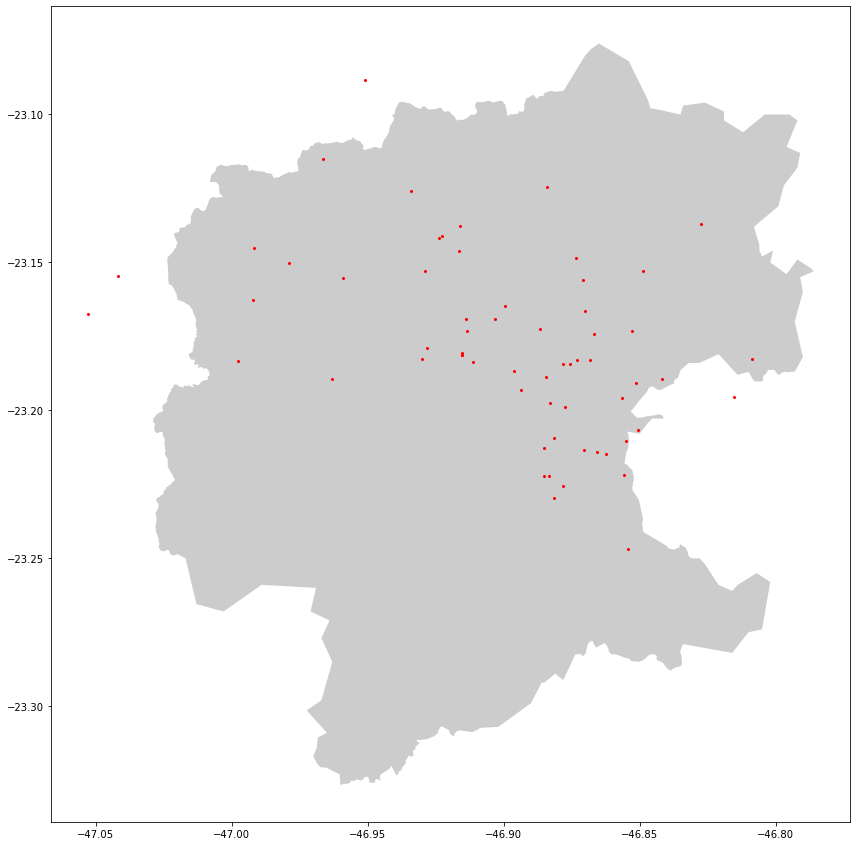

In [91]:
fig, ax = plt.subplots(figsize=(15, 15))
city.plot(ax=ax, color="grey", alpha=0.4)
geo_df.plot(ax=ax, markersize=4, color="red", marker="o")

In [92]:
jund = gpd.read_file("./sp_municipios_1/35MUE250GC_SIR.shp")
# jund = SP_cities

In [93]:
jund.head()

,NM_MUNICIP,CD_GEOCMU,geometry
0,CAIUÁ,3509106,"POLYGON ((-51.86001 -21.58072, -51.85892 -21.5..."
1,CASTILHO,3511003,"POLYGON ((-51.41936 -20.68108, -51.41942 -20.6..."
2,DRACENA,3514403,"POLYGON ((-51.48515 -21.42765, -51.48500 -21.4..."
3,ESTRELA DO NORTE,3515301,"POLYGON ((-51.57097 -22.39887, -51.57099 -22.3..."
4,EUCLIDES DA CUNHA PAULISTA,3515350,"POLYGON ((-52.44569 -22.60828, -52.44569 -22.6..."


In [94]:
jund = jund[jund["NM_MUNICIP"] == "JUNDIAÍ"]["geometry"].values[0]

In [95]:
geo_df = geo_df[geo_df["geometry"].apply(lambda x: x.within(jund))]

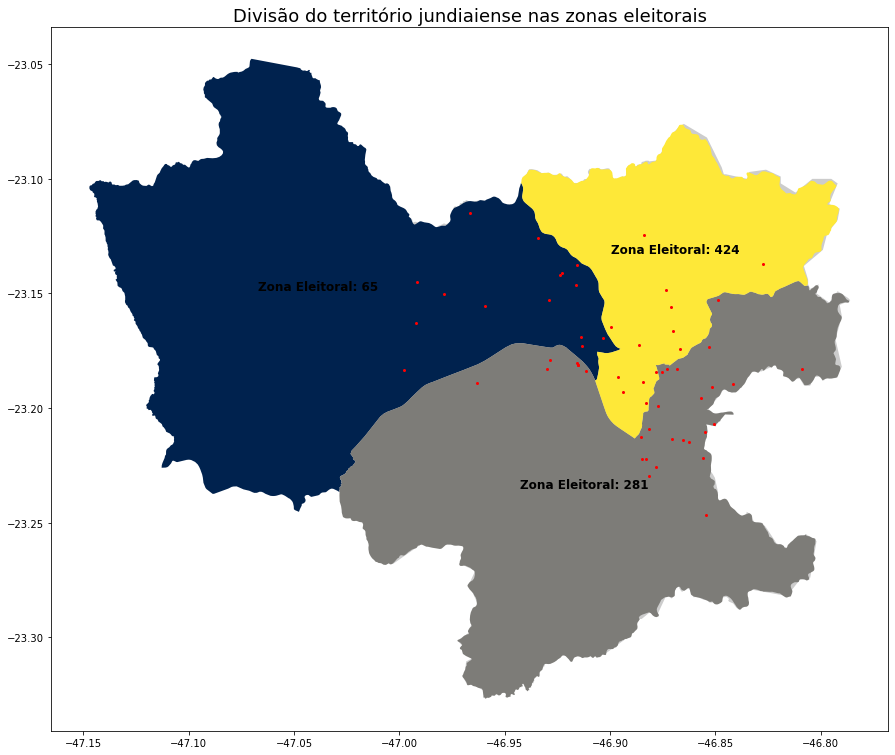

In [119]:
fig, ax = plt.subplots(figsize=(15, 15))
city.plot(ax=ax, color="grey", alpha=0.4)
geo_jund.plot(ax=ax, cmap = "cividis")
geo_df.plot(ax=ax, markersize=4, color="red", marker="o")

plt.title('Divisão do território jundiaiense nas zonas eleitorais', fontsize=18)

for _, row in geo_jund.iterrows():
    
    hue = round(row['Candidato1'],2)
    
    plt.text(s = 'Zona Eleitoral: ' + str(row['ZEFINAL']), x = row['coords'][0], y = row['coords'][1],
            horizontalalignment = 'center', fontdict = {'weight': 'bold', 'size': 12})

#Descomentar o trecho abaixo para ver o nome dos bairros    
#geo_df.apply(lambda x: ax.annotate(s=x["BAIRRO"], xy=x.geometry.centroid.coords[0], ha='center', color="black", size = 7), axis=1);

In [97]:
geo_df

,VOTOS RECEBIDOS,BAIRRO,Zona,Seção,Endereco,Lat_long,Latitude,Longitude,geometry
0,392,VILA ARENS II,281,15,"VILA ARENS II, Jundiaí, São Paulo","(-46.8774198, -23.1989846)",-23.198985,-46.877420,POINT (-46.87742 -23.19898)
1,257,VILA VIANELO,424,209,"VILA VIANELO, Jundiaí, São Paulo","(-46.8829257, -23.1976488)",-23.197649,-46.882926,POINT (-46.88293 -23.19765)
3,224,VILA DAS HORTÊNCIAS,65,528,"VILA DAS HORTÊNCIAS, Jundiaí, São Paulo","(-46.9153883, -23.1813954)",-23.181395,-46.915388,POINT (-46.91539 -23.18140)
4,198,ANHANGABAÚ,424,19,"ANHANGABAÚ, Jundiaí, São Paulo","(-46.8937772, -23.1931207)",-23.193121,-46.893777,POINT (-46.89378 -23.19312)
5,138,VILA VIRGÍNIA,424,58,"VILA VIRGÍNIA, Jundiaí, São Paulo","(-46.8962348, -23.1865506)",-23.186551,-46.896235,POINT (-46.89623 -23.18655)
9,118,VILA RIO BRANCO,424,144,"VILA RIO BRANCO, Jundiaí, São Paulo","(-46.8864952, -23.1726244)",-23.172624,-46.886495,POINT (-46.88650 -23.17262)
10,114,VILA HELENA,281,188,"VILA HELENA, Jundiaí, São Paulo","(-46.8815876, -23.2092612)",-23.209261,-46.881588,POINT (-46.88159 -23.20926)
11,111,JARDIM ERMIDA II,281,282,"JARDIM ERMIDA II, Jundiaí, São Paulo","(-46.963165, -23.1892781)",-23.189278,-46.963165,POINT (-46.96316 -23.18928)
12,93,PONTE SÃO JOÃO,424,233,"PONTE SÃO JOÃO, Jundiaí, São Paulo","(-46.8755208, -23.1844748)",-23.184475,-46.875521,POINT (-46.87552 -23.18447)
14,89,ENGORDADOURO,65,549,"ENGORDADOURO, Jundiaí, São Paulo","(-46.9290274, -23.1529987)",-23.152999,-46.929027,POINT (-46.92903 -23.15300)


In [98]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

geo_df["votos_size"] = mm.fit_transform(geo_df[["VOTOS RECEBIDOS"]])

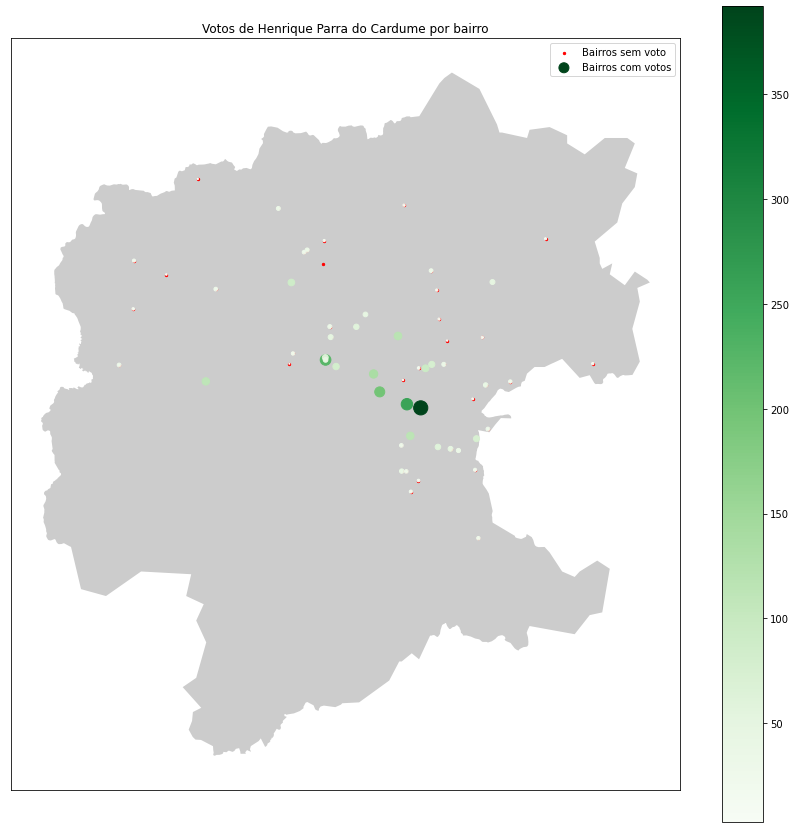

In [99]:
candidate = "Henrique Parra do Cardume"

max_amount = float(geo_df["VOTOS RECEBIDOS"].max())

fig, ax = plt.subplots(figsize=(15, 15))
city.plot(ax=ax, color="grey", alpha=0.4)


### We plot all locations in red to represent without votes. If there are votes they, they will be covered
geo_df.plot(ax=ax, markersize=5.5, color="red", marker="o", label="Bairros sem voto")


geo_df.plot(column="VOTOS RECEBIDOS", 
             ax=ax, 
             markersize=200 * geo_df["votos_size"], 
             marker="o", 
             vmax=max_amount,
             cmap="Greens", 
             legend=True,
             label="Bairros com votos")


#geo_df.apply(lambda x: ax.annotate(s=x["BAIRRO"], xy=x.geometry.centroid.coords[0], ha='center', color="blue"), axis=1);

plt.xticks([], [])
plt.yticks([], [])
plt.title("Votos de " + candidate + " por bairro")
plt.legend()
plt.show()

<ipython-input-111-91eb0b92338f>:27: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  geo_df.nlargest(5,"VOTOS RECEBIDOS").apply(lambda x: ax.annotate(s=x["BAIRRO"], xy=x.geometry.centroid.coords[0], ha='center', rotation = 45, color="black", size = 8), axis=1);


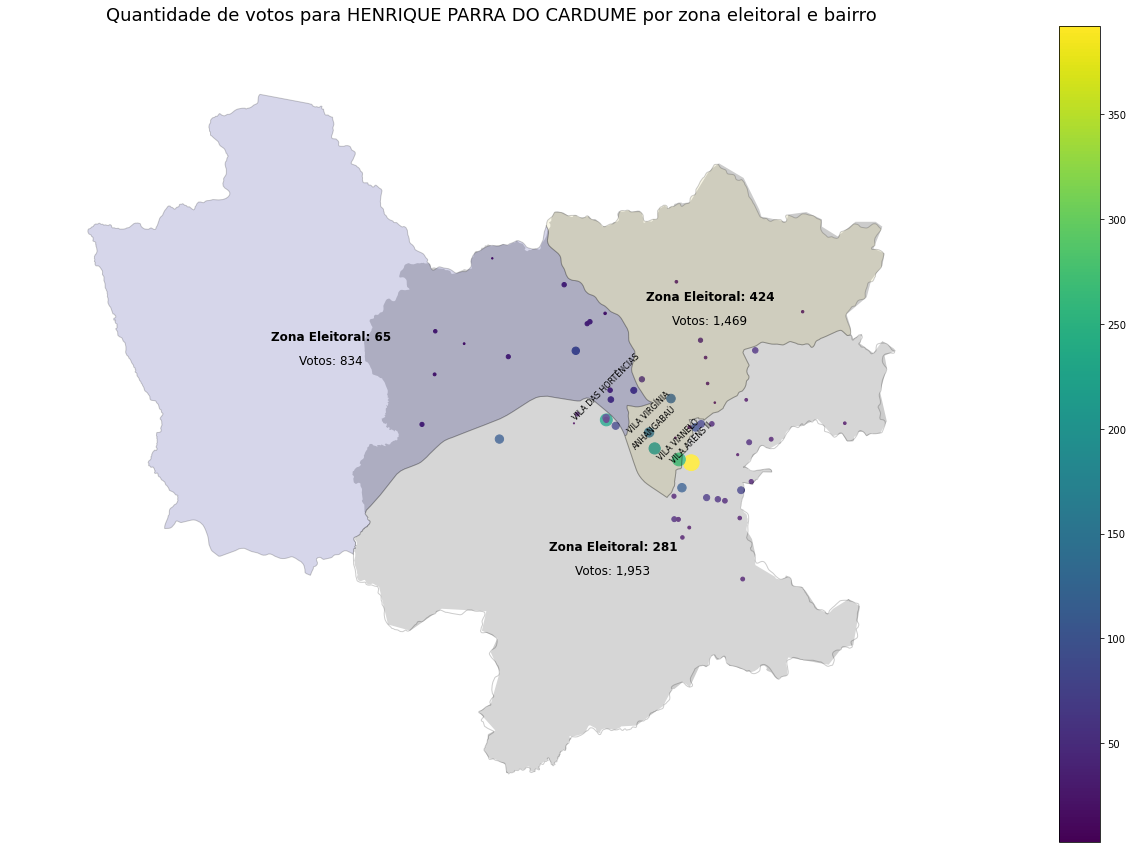

In [111]:
fig, ax = plt.subplots(figsize=(30, 15))
city.plot(ax=ax, color="grey", alpha=0.4)
gplt.choropleth(geo_jund, ax = ax, hue = 'Candidato1', legend = False, alpha = 0.2, cmap = 'terrain')
plt.title('Quantidade de votos para ' + candidato +  ' por zona eleitoral e bairro', fontsize=18)

geo_df.plot(column="VOTOS RECEBIDOS", 
             ax=ax, 
             markersize=250 * geo_df["votos_size"], 
             marker="o", 
             vmax=max_amount,
             cmap="viridis", 
             legend=True,
             alpha = 1.0,
             label="Bairros com votos")

for _, row in geo_jund.iterrows():
    
    hue = round(row['Candidato1'],2)
    
    plt.text(s = 'Zona Eleitoral: ' + str(row['ZEFINAL']), x = row['coords'][0], y = row['coords'][1],
            horizontalalignment = 'center', fontdict = {'weight': 'bold', 'size': 12})
    
    plt.text(s='Votos: ' + f'{hue:,}', x=row['coords'][0],y = row['coords'][1] - 0.01 ,
          horizontalalignment='center', fontdict = {'size': 12})

#geo_df[geo_df["VOTOS RECEBIDOS"] > 200].apply(lambda x: ax.annotate(s=x["BAIRRO"], xy=x.geometry.centroid.coords[0], ha='center', rotation = 45, color="blue"), axis=1);
geo_df.nlargest(5,"VOTOS RECEBIDOS").apply(lambda x: ax.annotate(s=x["BAIRRO"], xy=x.geometry.centroid.coords[0], ha='center', rotation = 45, color="black", size = 8), axis=1);
#geo_df[geo_df["VOTOS RECEBIDOS"] > 200].apply(lambda x: ax.annotate(s=x["VOTOS RECEBIDOS"], xy=x.geometry.centroid.coords[0], ha='right', color="blue"), axis=1);

#ha="center", va="center", rotation=45
